In [1]:
# For importing utils
import sys
sys.path.append("..")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, merge, pos_encodings, warmup):
    results_path = '/Users/xiulinyang/Desktop/test/mission-impossible-language-models/perplexities/perplexity_results/shuffle_control_{}_{}/randinit_seed{}_test_shuffle_control_{}_{}.csv'
    for file_data in file_info:
        lang, lang2, vocab_size, marker, linestyle, legend_name= file_data

        all_seeds_gmeans = []
        for seed in seeds:
            df = pd.read_csv(results_path.format(lang, lang2, seed, lang, vocab_size),lineterminator='\n')
            gmeans = []
            min_means = []
            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))
                min_means.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))
                
            if merge:
                gmeans = [min(min_means)]
            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)
        lower_percentile = np.percentile(all_seeds_gmeans, 25, axis=0)
        upper_percentile = np.percentile(all_seeds_gmeans, 75, axis=0)
        
        # Calculate the error bars as the difference between the percentiles
        iqr_lower = means - lower_percentile  # Lower quartile error
        iqr_upper = upper_percentile - means  # Upper quartile error
        ax.errorbar(checkpoints, means, yerr=[iqr_lower, iqr_upper], marker=marker, markersize=4, linewidth=0.8,
                    color=PERTURBATIONS[f'{lang}_{vocab_size}']["color"],
                    linestyle=linestyle, label=legend_name)

            
        ax.set_title(title)
        if ax_i == 0:
            ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
        
        if not pos_encodings and title == "*Shuffle":
            ax.legend(fontsize=6)
        elif title == "*Shuffle":
            ax.legend(fontsize=8, framealpha=1)
        else:
            ax.legend(fontsize=8, framealpha=1)
        ax.grid(True, color="lightgray")
    # if merge:
    #     return average_values

In [ ]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, merge=False, pos_encodings=True, warmup=False):
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(16, 3*2), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)

    # Flatten axs to handle cases with multiple rows, or wrap in a list for single subplot
    axs_flat = [axs] if len(file_infos) == 1 else axs.flatten()

    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, merge, pos_encodings, warmup
        )

    # Turn off unused subplots
    for ax in axs_flat[len(file_infos):]:
        ax.axis("off")  # Hide extra plots

    plt.tight_layout()
    plt.savefig("tokenization_results.pdf", format="pdf", bbox_inches="tight")  # Save first
    plt.show()  # Then show

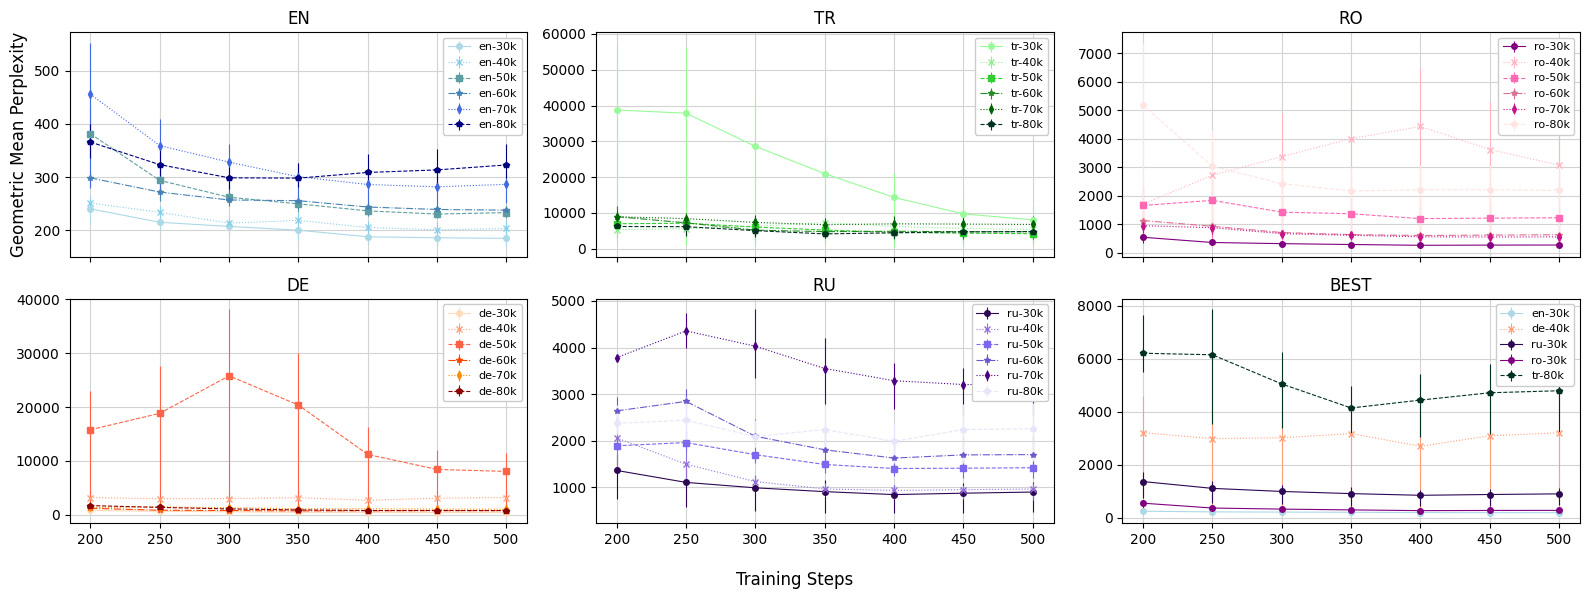

In [ ]:
MAX_TRAINING_STEPS = 500
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 50))
SEEDS = [42,76,81]
# Consistent markers for data sizes
marker_info = {
    "30k": 'o',
    "40k": 'x',
    "50k": 's',
    "60k": '*',
    "70k": 'd',
    "80k": 'p'
}

en_info = [
    ("en", "EN", "30000", marker_info["30k"], "-", 'en-30k'),  # Dodger Blue
    ("en", "EN", "40000", marker_info["40k"], ":", 'en-40k'),  # Steel Blue
    ("en", "EN", "50000", marker_info["50k"], "--", 'en-50k'),  # Cadet Blue
    ("en", "EN", "60000", marker_info["60k"], "-.", 'en-60k'),  # New
    ("en", "EN", "70000", marker_info["70k"], ":", 'en-70k'),  # New
    ("en", "EN", "80000", marker_info["80k"], "--", 'en-80k'),  # New
]

de_info = [
    ("de", "DE", "30000", marker_info["30k"], "-", 'de-30k'),  # Orange-Red
    ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
    ("de", "DE", "50000", marker_info["50k"], "--", 'de-50k'),  # Light Salmon
    ("de", "DE", "60000", marker_info["60k"], "-.", 'de-60k'),  # New
    ("de", "DE", "70000", marker_info["70k"], ":", 'de-70k'),  # New
    ("de", "DE", "80000", marker_info["80k"], "--", 'de-80k'),  # New
]

ru_info = [
    ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
    ("ru", "RU", "40000", marker_info["40k"], ":", 'ru-40k'),  # Medium Purple
    ("ru", "RU", "50000", marker_info["50k"], "--", 'ru-50k'),  # Blue Violet
    ("ru", "RU", "60000", marker_info["60k"], "-.", 'ru-60k'),  # New
    ("ru", "RU", "70000", marker_info["70k"], ":", 'ru-70k'),  # New
    ("ru", "RU", "80000", marker_info["80k"], "--", 'ru-80k'),  # New
]

ro_info = [
    ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
    ("ro", "RO", "40000", marker_info["40k"], ":", 'ro-40k'),  # Orchid
    ("ro", "RO", "50000", marker_info["50k"], "--", 'ro-50k'),  # Thistle
    ("ro", "RO", "60000", marker_info["60k"], "-.", 'ro-60k'),  # New
    ("ro", "RO", "70000", marker_info["70k"], ":", 'ro-70k'),  # New
    ("ro", "RO", "80000", marker_info["80k"], "--", 'ro-80k'),  # New
]

tr_info = [
    ("tr", "TR", "30000", marker_info["30k"], "-", 'tr-30k'),  # Forest Green
    ("tr", "TR", "40000", marker_info["40k"], ":", 'tr-40k'),  # Lime Green
    ("tr", "TR", "50000", marker_info["50k"], "--", 'tr-50k'),  # Lawn Green
    ("tr", "TR", "60000", marker_info["60k"], "-.", 'tr-60k'),  # New
    ("tr", "TR", "70000", marker_info["70k"], ":", 'tr-70k'),  # New
    ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New
    # ("tr", "TR", "pretrain", marker_info["80k"], "--", 'tr-pretrain'),  # New
]

multilingual_info =[("en", "EN", "30000", marker_info["30k"], "-", 'en-30k'),  # Dodger Blue
 ("de", "DE", "40000", marker_info["40k"], ":", 'de-40k'),  # Tomato
 ("ru", "RU", "30000", marker_info["30k"], "-", 'ru-30k'),  # Slate Blue
 ("ro", "RO", "30000", marker_info["30k"], "-", 'ro-30k'),  # Medium Orchid
 ("tr", "TR", "80000", marker_info["80k"], "--", 'tr-80k'),  # New
]


plot_perplexities_grouped([en_info, tr_info, ro_info, de_info, ru_info, multilingual_info],['EN', 'TR', 'RO', 'DE', 'RU', 'BEST'], CHECKPOINTS, SEEDS)

In [14]:
from glob import glob
import pandas as pd

CHECKPOINTS = list(range(0, 1200 + 1, 100))
perp_csv = sorted(glob('perplexity_results/**/*.csv', recursive=True))
with open('perplexity_results_new.csv', 'w') as res:
    header = ['lang', 'perturb', 'seed'] + [f'checkpoint{ckpt}' for ckpt in CHECKPOINTS]
    res.write(','.join(header) + '\n')
    for p in perp_csv:
        row = []
        seed = p.split('seed')[1].split('_')[0]
        lang = p.split('/')[-2].split('_')[-1]
        perturb = '_'.join(p.split('/')[-2].split('_')[:-1])
        row.extend([lang, perturb, seed])
        all_seeds_gmeans = []
        df = pd.read_csv(p, lineterminator='\n')
        gmeans = [stats.gmean(df[f"Perplexities (ckpt {ckpt})"]) for ckpt in CHECKPOINTS]
        row += gmeans
        res.write(','.join(map(str, row)) + '\n')



perplexity_results/perturb_adj_num_EN/randinit_seed41_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_EN/randinit_seed53_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_EN/randinit_seed81_test_perturb_adj_num_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed41_test_perturb_adj_num_np_det_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed41_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed53_test_perturb_adj_num_np_det_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed53_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed81_test_perturb_adj_num_np_det_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_EN/randinit_seed81_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_adj_num_np_det_IT/randinit_seed41_test_perturb_adj_num_np_det_it_pretrain

/opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
/opt/anaconda3/envs/mission/lib/python3.9/site-packages/numpy/_core/_methods.py:140: RuntimeWarning: invalid value encountered in scalar divide


perplexity_results/perturb_np_num_det_adj_EN/randinit_seed41_test_shuffle_control_aann_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed41_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed41_test_shuffle_control_nnda_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_perturb_np_num_det_adj_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_shuffle_control_aann_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_shuffle_control_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed53_test_shuffle_control_nnda_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed81_test_perturb_np_num_det_adj_en_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed81_test_shuffle_control_aann_pretrained.csv
perplexity_results/perturb_np_num_det_adj_EN/randinit_seed81_test_shuffle_co